# NeuroCluster:
<font size= 4> Non-parametric cluster-based permutation testing to identify neurophysiological encoding of continuous variables with time-frequency resolution

First Authors: Alexandra Fink-Skular & Christina Maher  \
Updated: 08/26/2024 by AFS

In [ ]:
### current pip install error message
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# mkl-fft 1.3.6 requires mkl, which is not installed.

# spyder 5.1.5 requires pyqt5<5.13, which is not installed.
# spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
# spyder-kernels 2.1.3 requires jupyter-client<7,>=5.3.4, but you have jupyter-client 8.0.2 which is incompatible.

# Successfully installed debugpy-1.8.5 ipykernel-6.21.0 ipython-8.12.3 joblib-1.2.0 jupyter_client-8.0.2 matplotlib-3.6.3 numpy-1.23.5 pandas-1.5.3 scipy-1.10.0 seaborn-0.13.2 statsmodels-0.13.5 tqdm-4.64.1


# 'install_requires' must be a string or list of strings containing valid project/version requirement specifiers; Expected end or semicolon (after name and no valid version specifier)
#     anyio=4.4.0=pypi_0
#          ^


In [4]:
# load required libraries
import numpy as np
import pandas as pd
from glob import glob
import datetime
from IPython import display
import NeuroCluster



In [5]:

%load_ext autoreload
%autoreload 2

In [7]:
# If you are running NeuroCluster from a local repo (not through a virtual environment package install)
user_base_dir   = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/neuro_cluster_proj/'
# user_base_dir   = '/Path/To/NeuroCluster/NeuroCluster/'
sample_data_dir = f'{user_base_dir}NeuroCluster/data/'
results_dir     = f'{user_base_dir}NeuroCluster/results/'

# Let's store the date so we can keep track of versions
date = datetime.date.today().strftime('%m%d%Y')

In [8]:
# # using package data

# data_dir = pkg_resources.resource_filename('LFPAnalysis', '../data')

# # Construct the full path to your file
# file_path = os.path.join(data_dir, 'YBA_ROI_labelled.xlsx')

# print(file_path)
# YBA_ROI_labels = pd.read_excel(file_path)
# YBA_ROI_labels['Long.name'] = YBA_ROI_labels['Long.name'].str.lower().str.replace(" ", "")

In [9]:
# load custom functions
# import sys
# sys.path.append(f'{user_base_dir}NeuroCluster/')
# import NeuroCluster
# from NeuroCluster import tfr_cluster_test
# from NeuroCluster import helper_utils
# from NeuroCluster import plotting_utils

In [10]:
with open(f'{user_base_dir}NeuroCluster/requirements.txt') as f:
    required = f.read().splitlines()

print(f'Required packages: {required}')
# conda create --name <env> --file <this file>'

Required packages: ['anyio==4.4.0', 'appnope==0.1.4', 'argon2-cffi==23.1.0', 'argon2-cffi-bindings==21.2.0', 'arrow==1.3.0', 'asttokens==2.4.1', 'async-lru==2.0.4', 'attrs==23.2.0', 'Babel==2.15.0', 'backcall==0.2.0', 'beautifulsoup4==4.12.3', 'bleach==6.1.0', 'certifi==2024.7.4', 'cffi==1.16.0', 'charset-normalizer==3.3.2', 'comm==0.2.2', 'contourpy==1.2.1', 'cycler==0.12.1', 'debugpy==1.8.2', 'decorator==5.1.1', 'defusedxml==0.7.1', 'entrypoints==0.4', 'exceptiongroup==1.2.2', 'executing==2.0.1', 'fastjsonschema==2.20.0', 'fonttools==4.53.1', 'fqdn==1.5.1', 'h11==0.14.0', 'httpcore==1.0.5', 'httpx==0.27.0', 'idna==3.7', 'intel-openmp==2023.2.0', 'ipykernel==6.21.0', 'ipython==8.12.3', 'ipython-genutils==0.2.0', 'ipywidgets==8.0.4', 'isoduration==20.11.0', 'jedi==0.19.1', 'Jinja2==3.1.4', 'joblib==1.2.0', 'json5==0.9.25', 'jsonpointer==3.0.0', 'jsonschema==4.23.0', 'jsonschema-specifications==2023.12.1', 'jupyter-events==0.10.0', 'jupyter-lsp==2.2.5', 'jupyter_client==7.4.4', 'jupyter

# Neurocluster Workflow

This notebook performs a nonparametric permutation-based cluster test on continuous behavioral predictors for one example electrode. The workflow is outlined schematically below.

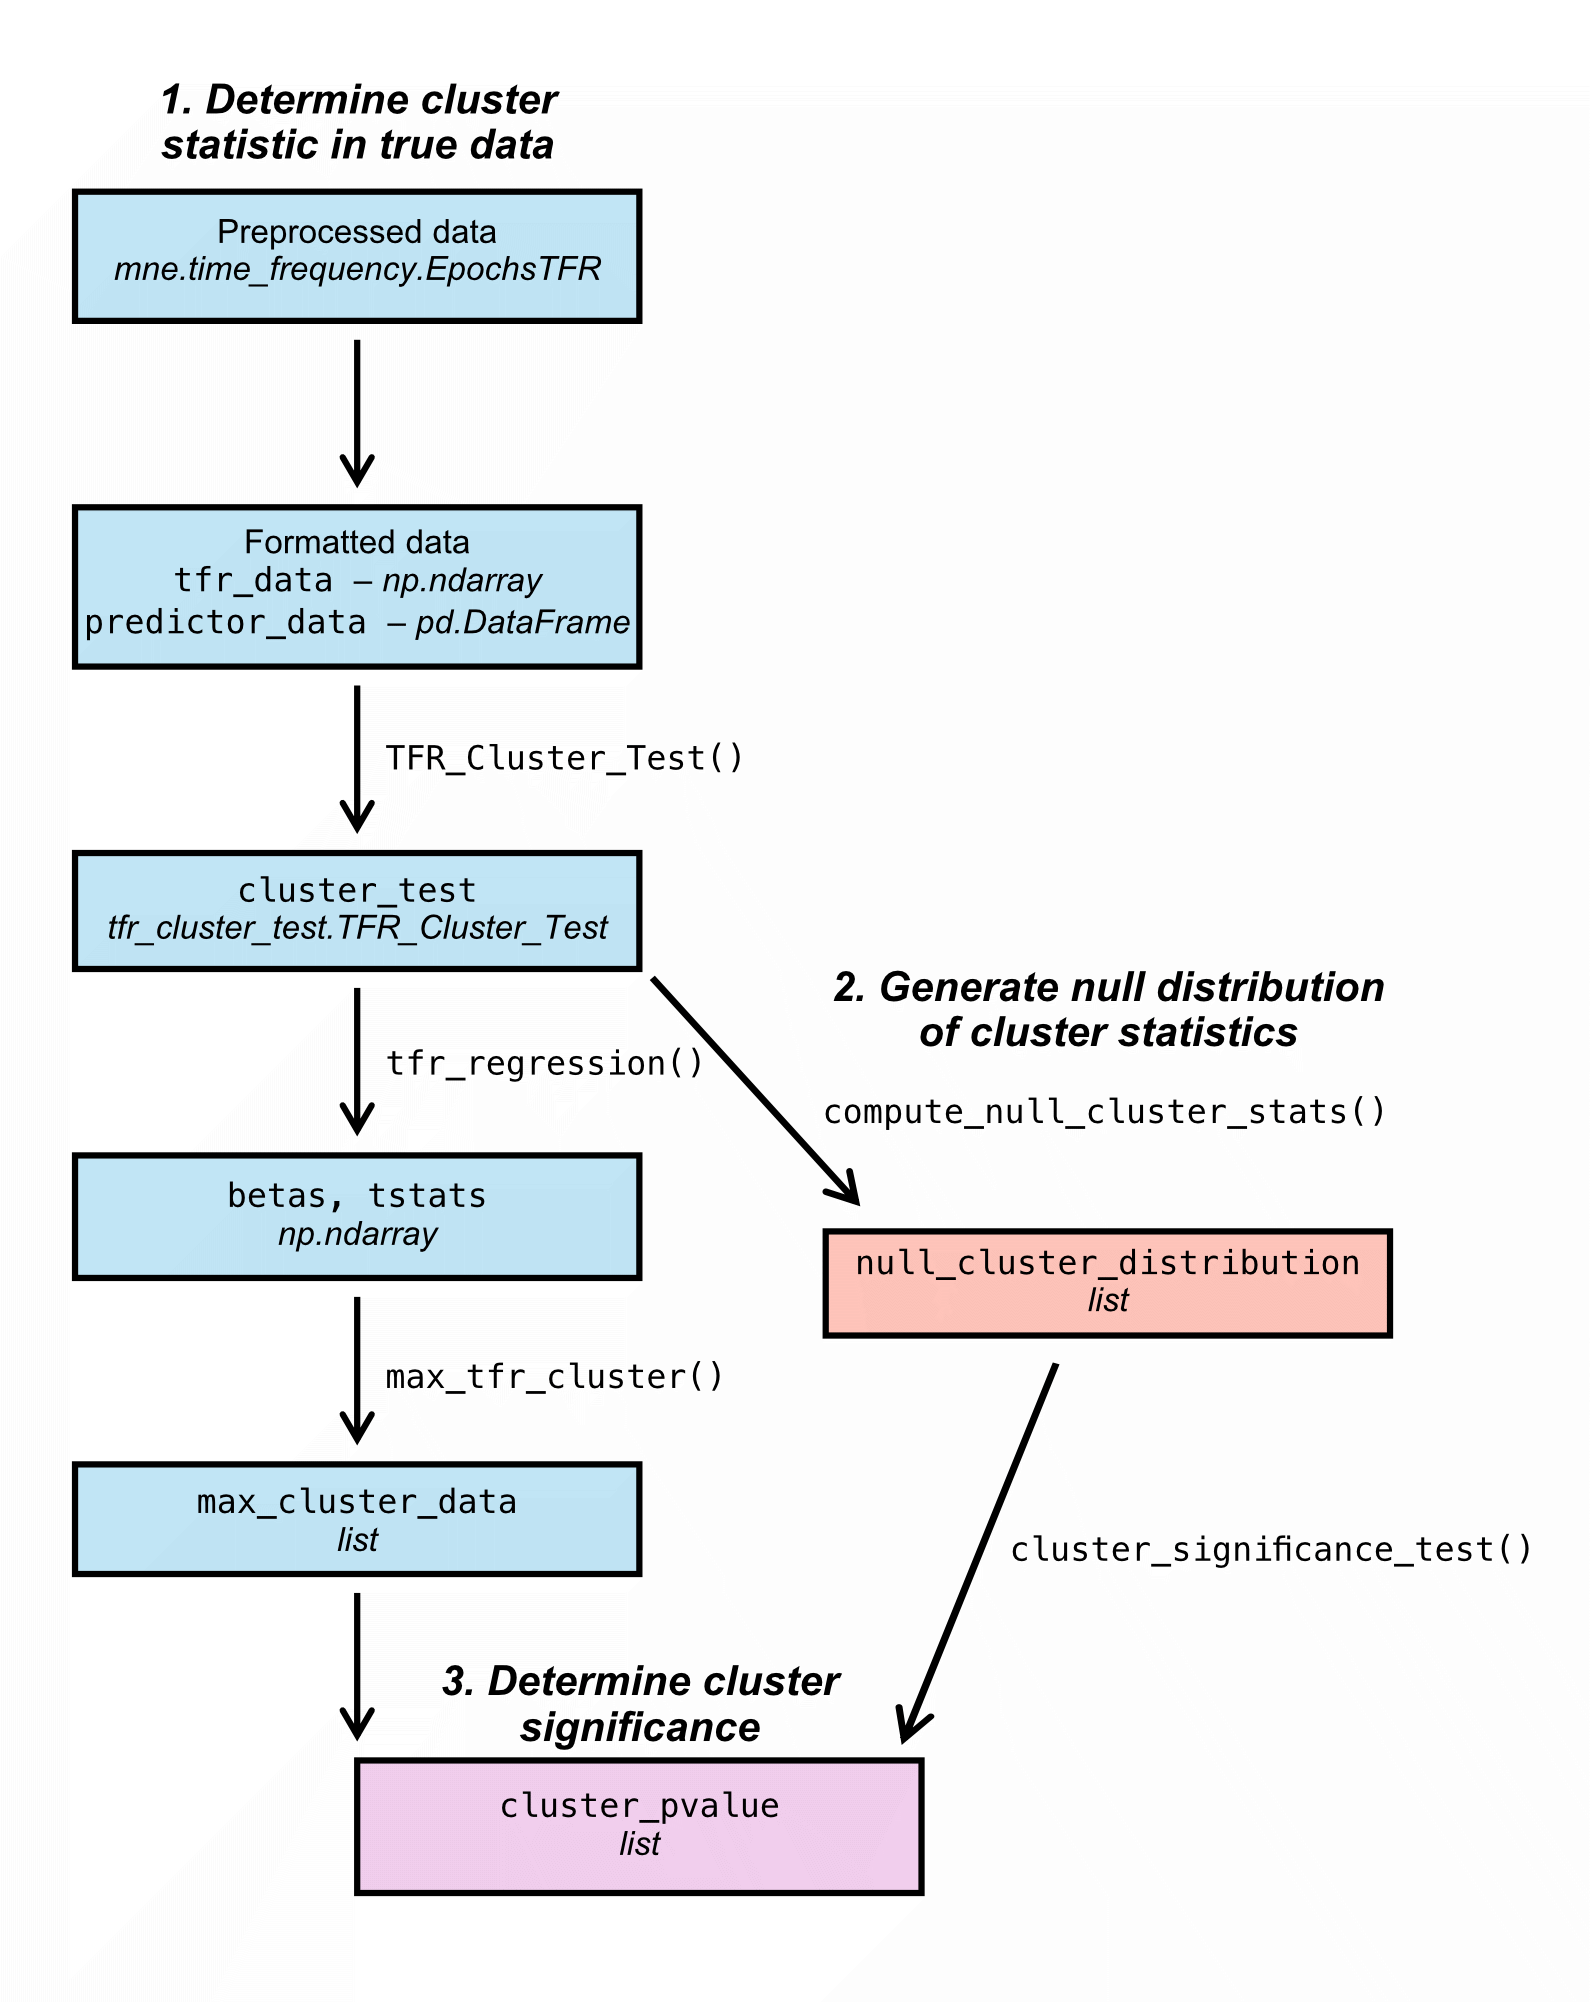

In [11]:
display.Image(f"{user_base_dir}/NeuroCluster/workflow/workflow.png",width=750)

# Step 1: Format input data (neural and behavioral)

The sample data for this notebook includes: 
- neural data: np.array (n_channels x n_trials x n_freqs x n_times)
- behavior data: pd.DataFrame (n_trials x n_variables)

These variables are extracted from an `mne.time_frequency.EpochsTFR` which is a spatiotemporal representation of neural data that includes power across trials, frequencies, and timepoints. Note, for this notebook we provide the neural and behavioral data in `np.array` *a priori*. These data can be found in the `sample_data_dir`.

Here is some example code, loading an `EpochsTFR` following preprocessing with  [MNE-Python](https://mne.tools/stable/index.html) and creating a neural data file (i.e., `channel_13.npy`) and our behavioral regressors (i.e., `sample_behavior.csv`):

`# load EpochsTFR data`


`power_epochs = mne.time_frequency.read_tfrs(fname=f'{tfr_dir}{subj_id}_tfr.h5')[0]`



`# save data from each channel to a .npy file`


`for i in range(len(power_epochs.info['ch_names'])):`

        channel = power_epochs.info['ch_names'][i]

        data = power_epochs.data[i]

        np.save(f'{results_dir}{channel}.npy', data)



`# save metadata as a numpy array to a .csv file`


`metadata = pd.DataFrame(power_epochs.metadata)`


`metadata.to_csv(f'{results_dir}sample_behavior.csv', index=False)`



In the following cell, let's load our template neural data into a dictionary and load the DataFrame of our behavioral predictors.

In [12]:
sample_ieeg_files = glob(f'{sample_data_dir}*.npy')
sample_ieeg_dict  = {f'{file.split("/")[-1].split(".")[0]}':np.load(file) for file in sample_ieeg_files}
ieeg_channels     = list(sample_ieeg_dict.keys())
sample_behav      = pd.read_csv(f'{sample_data_dir}sample_behavior.csv')

Let's define the behavioral variables we plan to include as independent variables in our linear regression (`multi_reg_vars`) and the regressor of interest (`permute_var`) we will permute to determine whether significant clusters encoding this behavioral variable exist in our time x frequency data. All continuous predictors should be normalized. 

In [13]:
# set main predictor of interest for permutations *permute_var must be a continuous numeric variable*
permute_var = 'error'

# define subset of predictor variables from sample_behav to include in regression (should include permute_var)
multi_reg_vars = ['outcome','error']

# subset input dataframe to include only multi_reg_vars
predictor_data = sample_behav.copy()[multi_reg_vars]

# let's print the first few rows of the predictor data to make sure it looks right
predictor_data.head()


,outcome,error
0,good,2.264982
1,bad,0.650167
2,bad,0.160829
3,good,-0.573178
4,good,0.552299


# Step 2: Perform within-electrode cluster test.

First, let's create a variable called `tfr_data` which is a `np.array` (dimensions should correspond with number of trials x number of frequencies x number of timepoints)

In [14]:
# subset demo channel data from sample_ieeg_dict and store as tfr_data variable: np.array of (num epochs x num frequencies x num times)
demo_channel = 'channel_4'
tfr_data     = sample_ieeg_dict[demo_channel]

# check tfr_data dimensions - must be num trials, num frequencies, num timepoints
tfr_data.shape 
print(f'Number of trials for {demo_channel}: {tfr_data.shape[0]}')
print(f'Number of frequencies for {demo_channel}: {tfr_data.shape[1]}')
print(f'Number of timepoints for {demo_channel}: {tfr_data.shape[2]}')

Number of trials for channel_4: 150
Number of frequencies for channel_4: 30
Number of timepoints for channel_4: 1501


Next, let's create an instance of `TFR_Cluster_Test`. This will be used to run the cluster test. It requires the tfr_data, predictor_data, permute_var, and demo_channel as inputs.

In [15]:
help(NeuroCluster.TFR_Cluster_Test)

Help on class TFR_Cluster_Test in module NeuroCluster.NeuroCluster:

class TFR_Cluster_Test(builtins.object)
 |  TFR_Cluster_Test(tfr_data, predictor_data, permute_var, ch_name, **kwargs)
 |  
 |  Single-electrode neurophysiology object class to identify time-frequency resolved neural activity correlates of complex behavioral variables using non-parametric 
 |  cluster-based permutation testing.   
 |  
 |  Attributes
 |  ----------
 |  tfr_data       : (np.array) Single electrode tfr data matrix. Array of floats (n_epochs,n_freqs,n_times). 
 |  tfr_dims       : (tuple) Frequency and time dimensions of tfr_data. Tuple of integers (n_freq,n_times). 
 |  ch_name        : (str) Unique electrode identification label. String of characters.
 |  predictor_data : (pd.DataFrame) Regressors from task behavior with continuous, discreet, or categorical data. DataFrame of (rows=n_epochs,columns=n_regressors). 
 |  permute_var    : (str) Column label for primary regressor of interest.
 |    
 |  Met

In [15]:
cluster_test  = NeuroCluster.TFR_Cluster_Test(tfr_data,predictor_data,permute_var,demo_channel)
cluster_test

Now, we are reading to run our linear regression based on the dependent neural variable (`tfr_data`) and independent behavioral variables (`predictor_data`, `permute_var`) we passed as inputs to our `TFR_Cluster_Test` object. This will return pixel-level **β coefficients** and corresponding **t-statistics** for our TFR data in one electrode.

In [16]:
betas, tstats = cluster_test.tfr_regression()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

Let's plot the **β coefficients** to give us an idea of the neural encoding pattern for our continuous predictor of interest.

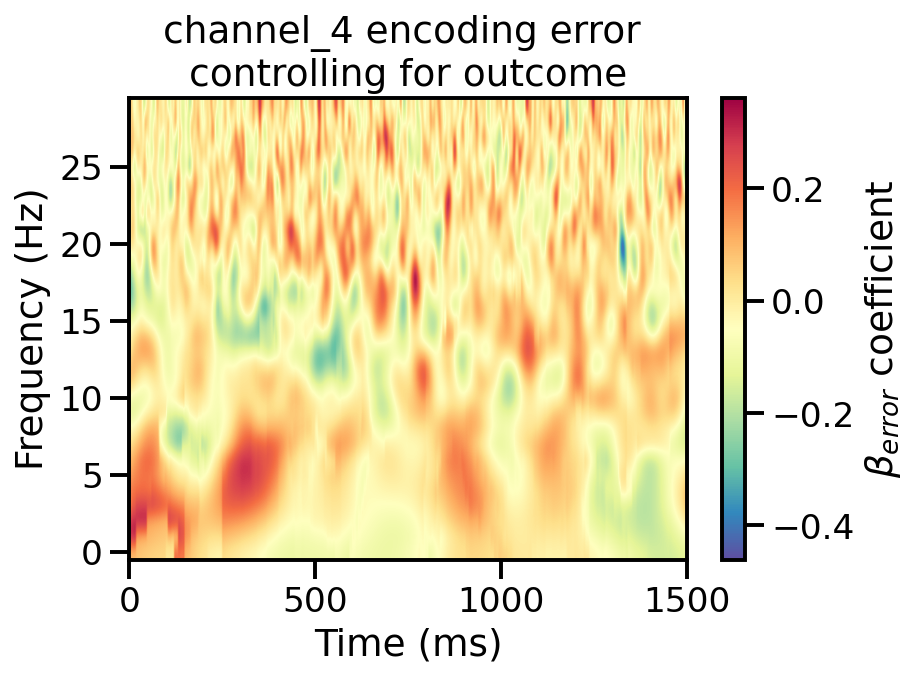

In [12]:
plot_beta_coef(betas,cluster_test,figsize=(6,4),dpi=150,sns_context='talk',cmap='Spectral_r')

We can also plot the **t-statistics** that correspond with the **β coefficient** for each time-frequency point.

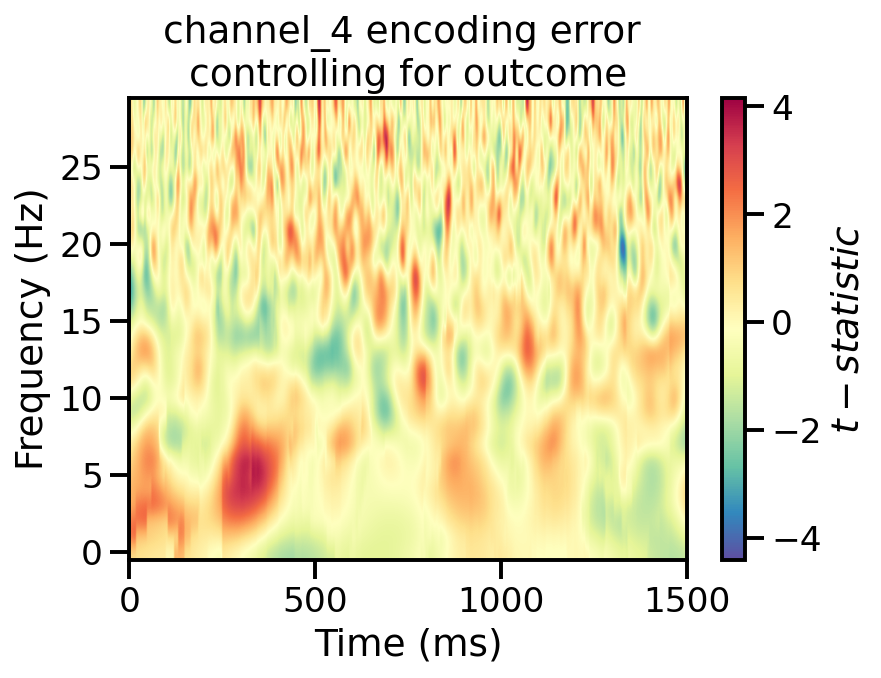

In [13]:
plot_tstats(tstats,cluster_test,figsize=(6,4),dpi=150,sns_context='talk',cmap='Spectral_r')

Let's highlight **clusters** (defined as consecutive time x frequency points) with significant t-statistics. We can do this separately for both positive and negative clusters. 

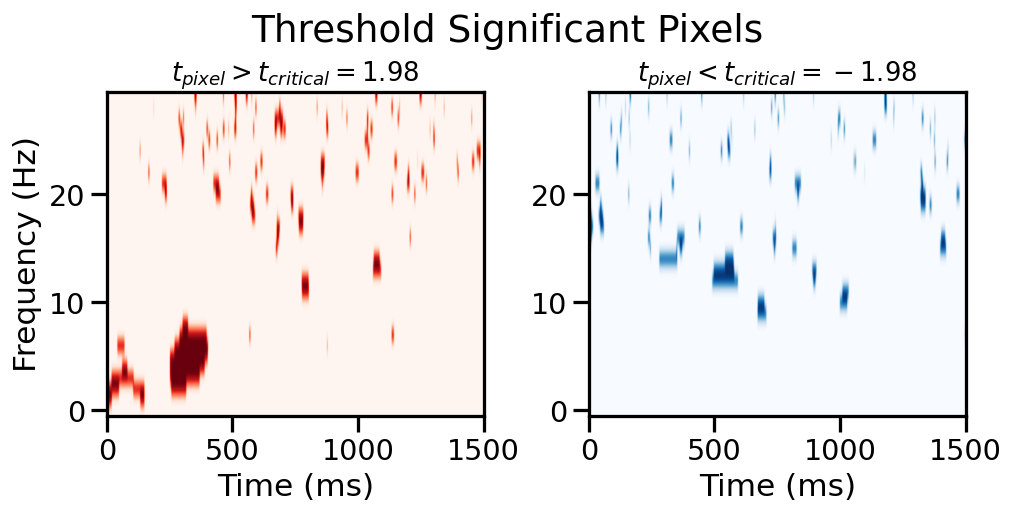

In [14]:
plot_clusters(tstats,cluster_test,figsize=(8,4),dpi=125,sns_context='talk')

# Step 3: Calculate True Cluster Statistic(s) 

Now, we will identify the largest cluster (either/both positive and negative) and save the **cluster statistic** which will be our test statistic against our non-parametric null distribution. `max_tfr_cluster()` returns a dictionary containing the **cluster statistic**:`cluster_stat` and its associated **freq_idx**: `freq_idx` and **time_idx**:`time_idx`.

In [15]:
# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,output='all',alternative='two-sided')
print(f'Max positive cluster dictionary: {max_cluster_data[0]}')
print(f'Max negative cluster dictionary: {max_cluster_data[1]}')

Max positive cluster dictionary: {'cluster_stat': 2108.9096700212563, 'freq_idx': (2, 8), 'time_idx': (250, 401)}
Max negative cluster dictionary: {'cluster_stat': -527.2224197852879, 'freq_idx': (12, 14), 'time_idx': (489, 591)}


Let's plot our largest cluster and its associated **cluster statistic**

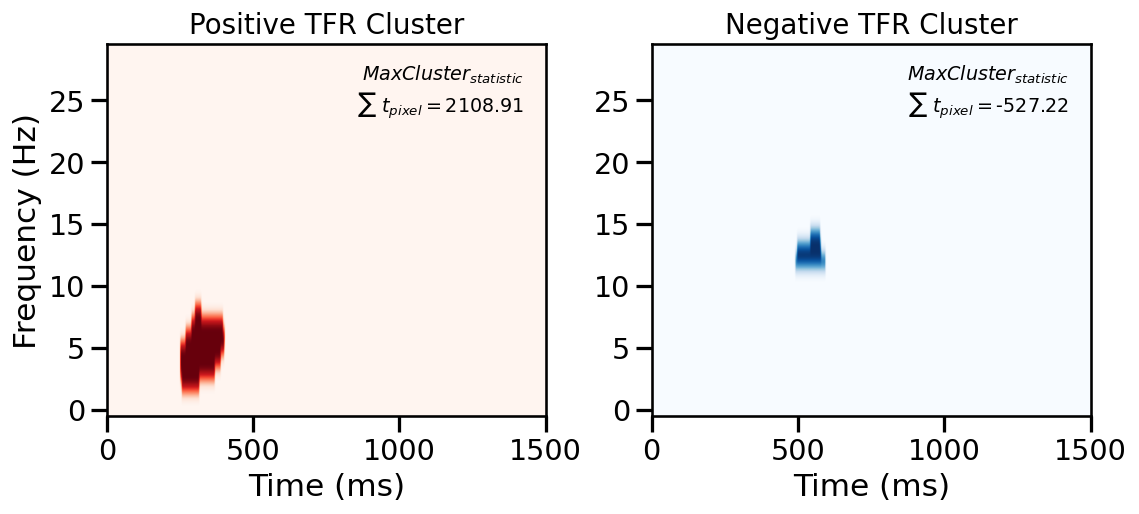

In [16]:
plot_max_clusters(cluster_test,tstats,alternative='two-sided',figsize=(9,4),dpi=125,sns_context='talk')

If I set `which_cluster == 'positive'`, I can just plot the largest positive cluster.

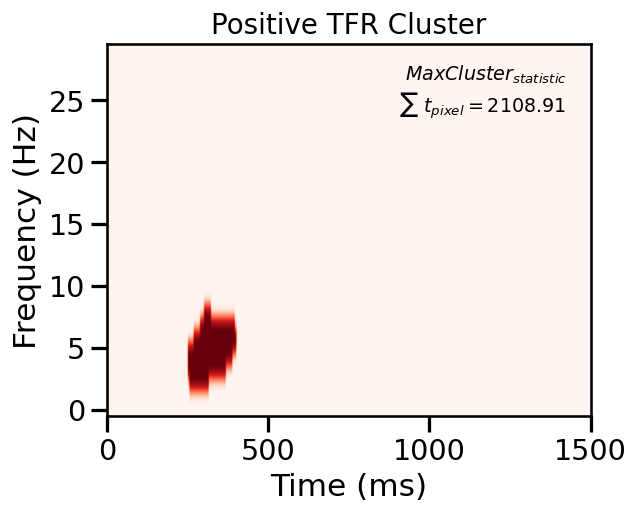

In [17]:
plot_max_clusters(cluster_test,tstats,alternative='two-sided',which_cluster='positive',figsize=(5,4),dpi=125,sns_context='talk')


Comparatively, if I set `which_cluster == 'negative'`, I can just plot the largest negative cluster.

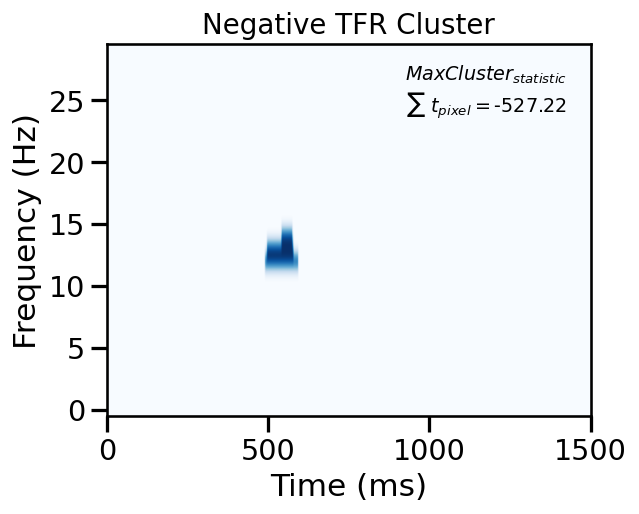

In [18]:
plot_max_clusters(cluster_test,tstats,alternative='two-sided',which_cluster='negative',figsize=(5,4),dpi=125,sns_context='talk')


# Step 4: Compute cluster p-value(s) from null distribution of cluster statistics. 
To generate the null distribution, perform non-parametric cluster-based permutation testing by randomly permuting predictor of interest (permute_var). 

At this point, we have computed the true cluster statistics from our neural (`tfr_data`) and behavioral data (`predictor_data`, `permute_var`). Next, we will permute our input data and re-run the cluster identification procedure on each permuted dataset. This will allow us to generate a null distribution of cluster statistics, which we can use to evaluate the statistical significance of the cluster statistics observed in our true data.

`compute_null_cluster_stats()` takes `num_permutations` as an input, which specifies the desired number of permutations. The function will permute the regressor of interest according to this number. It returns a list of null cluster statistics, with the length of the list depending on the tails of the test. Here we generated 100 null cluster statistics, `num_permutations=100`, but we recommend running at least 200 permutations (500 to 1000 is best practice). 

In [30]:
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=100)

In [31]:
null_cluster_distribution

[[525.1970430903092,
  206.8072572831138,
  730.1485680882163,
  407.8739477976277,
  413.1680879122552,
  578.947462909857,
  439.9211008018912,
  210.36374805663348,
  309.80043303643697,
  1065.77529554299,
  189.5955627706622,
  349.84709345665397,
  514.484941236525,
  159.23467776702668,
  275.50189918907904,
  581.171680842483,
  239.10622805122432,
  1296.7835039979889,
  265.0297222829066,
  403.0893905731851,
  224.45667368251983,
  3717.6988370936824,
  492.2314728178314,
  1474.8364203747128,
  407.39226143863345,
  398.03677371977267,
  206.56614978786624,
  468.64004219383435,
  222.4447885177498,
  308.36292366894907,
  832.9691424021165,
  1608.724911170823,
  154.41803297386787,
  345.62263124236443,
  3069.208509400957,
  1433.313021913235,
  202.01592946529252,
  347.1606527020529,
  925.6830972490534,
  375.9305042160252,
  1010.6427703979065,
  157.37500536527978,
  695.7984815162345,
  425.6175843051964,
  262.92809094957073,
  746.5838034311066,
  516.16841712429

We will compute the ***p*-value** associated with our true cluster statistics based on the null distributions we create using `cluster_significance_test()`.

In [32]:
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution) 
print(f'Positive cluster p-value: {cluster_pvalue[0]}')
print(f'Negative cluster p-value: {cluster_pvalue[1]}')

Positive cluster p-value: 0.06
Negative cluster p-value: 0.32


Let's create a plot showing the **null distribution(s)** we generated, with our true cluster statistic overlaid on top.

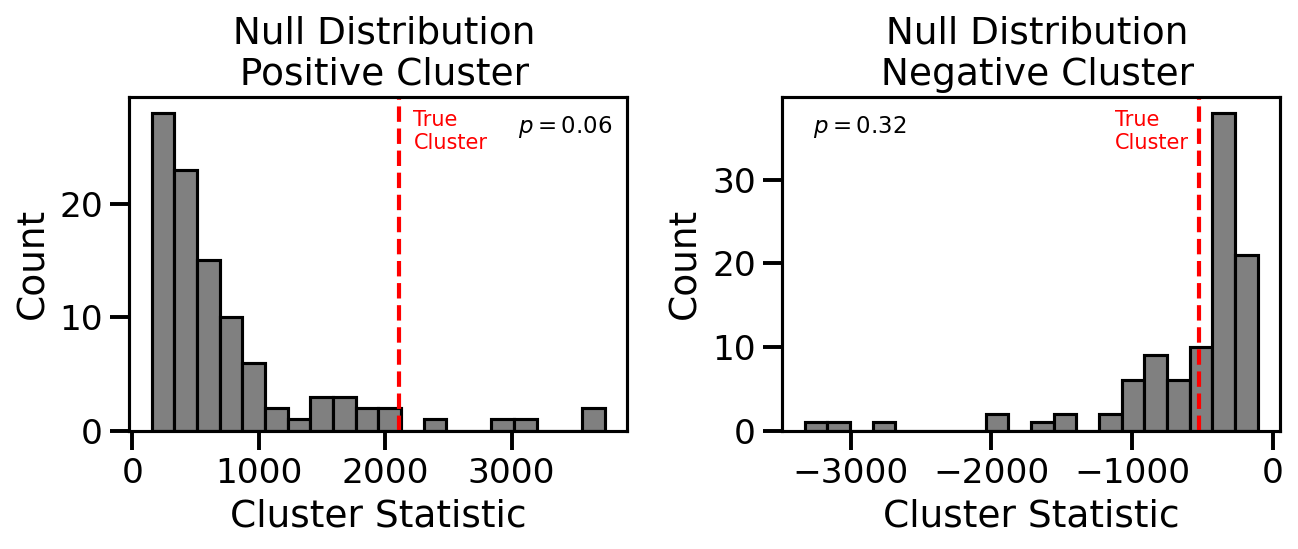

In [33]:
plot_null_distribution(null_cluster_distribution, max_cluster_data,cluster_pvalue,dpi=150)

# Let's run the entire pipeline at once and save plots. 

In [34]:
### NeuroCluster single electrode workflow: 

# Step 1: Create TFR_Cluster_Test Object
cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var,demo_channel,alternative='two-sided')

# Step 2: Run TFR regression to extract beta coefficients for predictor of interest (permute_var) & tstats for each pixel in TFR. Determine which t-statistics are significant based on the critical t-value and save a thresholded t-statistic matrix.
betas, tstats = cluster_test.tfr_regression()
tstat_threshold = cluster_test.threshold_tfr_tstat(tstats)

# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,output='all')

# Step 4: Create null distribution of maximum cluster statistics from permuted data
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=100)

# Step 5: Use null cluster statistic distribution from permutations to compute non-parametric p value 
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution) 

# Let's plot all the steps together and save the figures to a dictory that corresponds to the channel and predictor of interest. 
beta_plot,tstat_plot,cluster_plot,max_cluster_plot,null_distribution_plot = plot_neurocluster_results(betas,cluster_test, max_cluster_data, null_cluster_distribution, tstats, tstat_threshold,cluster_pvalue)

# Define the directory where you want to save the plots
output_directory = f'{results_dir}/{demo_channel}_{permute_var}'

# Create the directory if it doesn't exist
create_directory(output_directory)

# Save plots to the output directory
save_plot_to_pdf(beta_plot, output_directory, 'beta_plot.png')
save_plot_to_pdf(tstat_plot, output_directory, 'tstat_plot.png')
save_plot_to_pdf(cluster_plot, output_directory, 'cluster_plot.png')
save_plot_to_pdf(max_cluster_plot, output_directory, 'max_cluster_plot.png')
save_plot_to_pdf(null_distribution_plot, output_directory, 'null_distribution_plot.png')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 32784 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 45030 out of 45030 | elapsed:    8.5s finished
